In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [56]:
# папка со вмесми нашими данными
data_dir = Path("./captcha_images_v2/")

# Получаем всю важную информацию о наших данных
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
size_labels = list(set(len(label) for label in labels))
max_length = max(size_labels)
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Size labels: ", size_labels)
print('Max size label:', max_length)
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Размер батчей 
batch_size = 16

# Задаём стандартный размер для получаемых иозображений
img_width = 200
img_height = 50

# Не нужная штука, раньше нужна была т.к. у нас батчи теперь "динамически составные"
# downsample_factor = 4

# Maximum length of any captcha in the dataset


Number of images found:  1195
Number of labels found:  1195
Size labels:  [5, 6]
Max size label: 6
Number of unique characters:  21
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y', 'z']


Tensor of 1 - word

In [57]:
# Перевод чаров в числовой словарь
char_to_num = layers.StringLookup(
    vocabulary=list(characters), 
    mask_token=None
)

# Получаем чар из числового словаря
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), 
    mask_token=None, 
    invert=True
)

In [ ]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    """
        Разделение наших данных на тренировочные и на валидационные данные.
        Тестировать мы будем вручную.
    """

    size = len(images)
    indices = ops.arange(size)

    # Добавим рандом для наших данных 
    # В ЗАДАЧЕ С КАПЧАМИ ОБЯЗАТЕЛЬНО ТАК КАК РАНЕЕ МЫ СОРТИРОВАЛИ ВСЕ НАШИ КАРТИНКИ !!!!!!!!!!!
    if shuffle:
        indices = keras.random.shuffle(indices)

    # определяем количество в тренировочной выборке
    train_samples = int(size * train_size)

    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# Split data and 'всё гуд'
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

Дальше комменты на английском, т.к. английский знать надо !!!

In [ ]:
# Max size label
max_label_length = 6  

# Model input image dimensions 
img_height = 50
img_width = 250 

def encode_single_sample(img_path, label):
    # Read
    img = tf.io.read_file(img_path)
    
    # Decoding 
    img = tf.io.decode_png(img, channels=1)
    
    # Convert in normal format 0-1
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Verifies image dimensions and resizes to target size 
    #  (img_height = 50, img_width = 250 ) 
    #  if necessary
    current_shape = tf.shape(img)
    current_height = current_shape[0]
    current_width = current_shape[1]
    
    # Verifies image
    img = tf.cond(
        tf.equal(current_width, 300), # If case have 300px
        lambda: tf.image.crop_to_bounding_box(
            img,
            offset_height=0,          
            offset_width=25,          # left change 
            target_height=img_height,
            target_width=img_width    
        ),
        lambda: img 
    )
    # Fallback: resize to default dimensions
    img = ops.image.resize(img, [img_height, img_width])
    # Transponse 
    img = ops.transpose(img, axes=[1, 0, 2])
    
    # Char -> num -> len(num) == max_label_length
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    label = tf.pad(label, paddings=[[0, max_label_length - tf.shape(label)[0]]])
    
    return {"image": img, "label": label}

In [ ]:
# Data loading pipeline
# 1. Initializing dataset from in-memory arrays (paths+labels)
# 2. Apply preprocessing (decoding img and change label)
# 3. Configure batches and prefetching for optimal GPU utilization

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

NameError: name 'tf' is not defined

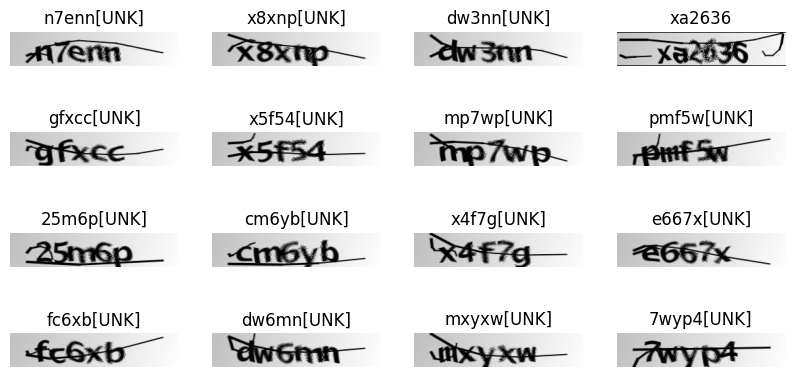

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

ТУТ ДОЛЖНА БЫТЬ КАРТИНКА КАК РАБОТАЕТ CTC слой


In [ ]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    """
        Computes the CTC (Connectionist Temporal Classification) loss for a batch of sequences
        
        Args:
            y_true: True values
            y_pred: Predict probabilies
            input_length, label_length: len data

        Return:
            Tensor containing the CTC for each sequences in the batch
    """

    # Remove singleton dimensions and change values in int32
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    
    # Create SparseTensor for label_true
    sparse_labels = ops.cast(
        # ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
        tf.sparse.from_dense(labels)
    )

    # Prepares predict for CTC loss calculation
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    # Calculate and return CTC
    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss( 
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )

# ===============================================================
# НАДО ТЕСТИРОВАТЬ МЕТОД РЕАЛИЗОВАН В ОСНОВНОЙ БИБЛИОТЕКЕ 
# ===============================================================


# def ctc_label_dense_to_sparse(labels, label_lengths):
#     label_shape = ops.shape(labels)
#     num_batches_tns = ops.stack([label_shape[0]])
#     max_num_labels_tns = ops.stack([label_shape[1]])

#     def range_less_than(old_input, current_input):
#         return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
#             max_num_labels_tns, current_input
#         )

#     init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
#     dense_mask = tf.compat.v1.scan(
#         range_less_than, label_lengths, initializer=init, parallel_iterations=1
#     )
#     dense_mask = dense_mask[:, 0, :]

#     label_array = ops.reshape(
#         ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
#     )
#     label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

#     batch_array = ops.transpose(
#         ops.reshape(
#             ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
#             tf.reverse(label_shape, [0]),
#         )
#     )
#     batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
#     indices = ops.transpose(
#         ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
#     )

#     vals_sparse = tf.compat.v1.gather_nd(labels, indices)

#     return tf.SparseTensor(
#         ops.cast(indices, dtype="int64"), 
#         vals_sparse, 
#         ops.cast(label_shape, dtype="int64")
#     )


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [ ]:
def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # ============== Warning ==============
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    # =====================================

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)

    # Update count features in 64
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x) # layer not UPlearn

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )

    # Optimizer
    opt = keras.optimizers.Adam()
    
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

NameError: name 'layers' is not defined

In [4]:
# TODO restore epoch count.
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

NameError: name 'keras' is not defined

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 250, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 250, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 125, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 125, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 62, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 62, 768)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 62, 64)         │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 62, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 62, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 62, 23)         │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,983 (1.65 MB)

 Trainable params: 432,983 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


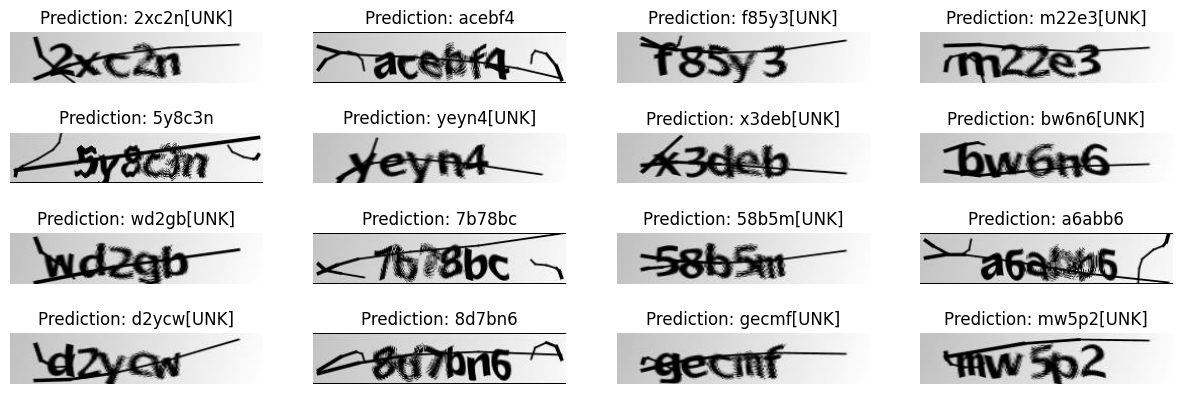

In [11]:
def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
dcnb23


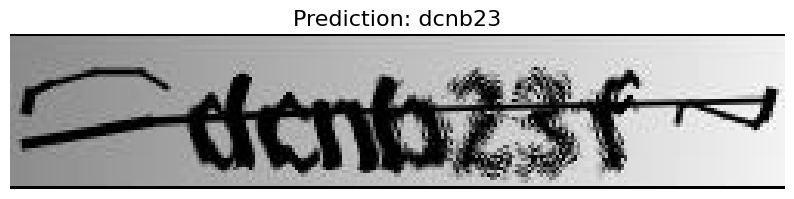

In [52]:
new_img = 'C:/Users/sinde/Downloads/Загрузка'

test_dataset = tf.data.Dataset.from_tensor_slices(([new_img], ['']))
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

pred_text = ''
img = ''

for batch in test_dataset.take(1):
    preds = prediction_model.predict(batch["image"])
    pred_text = decode_batch_predictions(preds)[0]  
    
    # Подготовка изображения
    img = (batch["image"][0, :, :, 0] * 255).numpy().astype(np.uint8)
    img = img.T  
    
    # Создаем график
    print(pred_text)
    plt.figure(figsize=(10, 3))
    plt.imshow(img, cmap="gray")
    plt.title(f"Prediction: {pred_text}", fontsize=16)
    plt.axis("off")
    plt.show()

In [ ]:
dir = 'C:/Users/sinde/Desktop/cap/captcha_images_v2'
source_path = new_img
    

output_path = os.path.join(dir, f"{pred_text}.png")
    
# Сохраняем изображение
plt.imsave(output_path, img, cmap='gray')
print(f"Изображение сохранено как: {output_path}")
    
if source_path:
    source_png = f"{source_path}"
    if os.path.exists(source_png):
        os.remove(source_png)
        print(f"Исходный файл удалён {source_png} ")

Изображение сохранено как: C:/Users/sinde/Desktop/cap/captcha_images_v2\dcnb23.png
Исходный файл C:/Users/sinde/Downloads/Загрузка удален
